# Conversation Trajectory

In [13]:
import os
import re
import sys
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('.')
sys.path.append('..')

from utils.pca_utils import L2MeanScaler, MeanScaler, compute_pca, plot_variance_explained


In [7]:
plt.style.use('./arena.mplstyle')

# Color palette for PC lines
PC_COLORS = [
    '#4a6fa5',  # muted blue
    '#c4a5a5',  # dusty rose
    '#7d9a78',  # sage green
    '#6b7b8c',  # slate
    '#b8977e',  # clay
    '#1a1a1a',  # charcoal
]

# Gradient background colormap (red = role-playing, blue = assistant-like)
from matplotlib.colors import Normalize, LinearSegmentedColormap
CMAP_RED_BLUE = LinearSegmentedColormap.from_list('RedBlue', ['#e63946', '#457b9d'])


class ThresholdNorm(Normalize):
    """Normalize with a threshold - values above threshold map to 1.0 (blue)."""
    
    def __init__(self, vmin, threshold):
        if vmin >= threshold:
            vmin = threshold - 1.0
        super().__init__(vmin=vmin, vmax=threshold)
        self.threshold = threshold
    
    def __call__(self, value, clip=None):
        return super().__call__(value, clip=True)


def add_gradient_background(ax, x_range, y_range, threshold=0, vmin=None, alpha=0.3):
    """Add a vertical gradient background based on y-axis values.
    
    Blue = assistant-like (at or above threshold)
    Red = role-playing (below threshold)
    """
    gradient = np.linspace(y_range[0], y_range[1], 256).reshape(-1, 1)
    
    if vmin is None:
        vmin = y_range[0]
    
    norm = ThresholdNorm(vmin=vmin, threshold=threshold)
    
    ax.imshow(gradient, aspect='auto', cmap=CMAP_RED_BLUE,
              extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
              origin='lower', norm=norm, zorder=0, alpha=alpha)

In [100]:
model = "qwen-3-32b"
auditor_model = "gpt-5"
layer = 32

acts_input_dir = f"/workspace/{model}/dynamics/{auditor_model}/default/activations"

In [102]:
def mean_auto_activations(acts_input_dir, regex_pattern, layer):
    """Extract (turns, hidden) slice for each file matching the regex pattern."""
    slices = []
    max_turns = 0
    H = None

    for file in os.listdir(acts_input_dir):
        if re.match(regex_pattern, file):
            A = torch.load(f"{acts_input_dir}/{file}", weights_only=False, map_location="cpu")['activations']
            T, _, H_cur = A.shape

            T_eff = T - (T % 2)     # drop last turn if odd (user ended conversation)
            if T_eff == 0:
                continue   

            max_turns = max(max_turns, T_eff)

            sl = A[:T_eff, layer, :]  # (T_eff, H_cur)
            slices.append(sl)

            if H is None:
                H = H_cur
            else:
                assert H == H_cur

    if len(slices) == 0:
        raise ValueError("No usable activations after dropping odd last turns.")

    # pad slices with shorter turns with NaN to (N, max_turns, H)
    N = len(slices)
    print(f"Padding {N} activations found to (100, {max_turns}, {H})")
    padded = torch.full((N, max_turns, H), float('nan'))
    for i, sl in enumerate(slices):
        T_eff = sl.shape[0]
        padded[i, :T_eff, :] = sl

    # mean over the first two dimensions
    mean_acts = torch.nanmean(padded, dim=0)
    return mean_acts


domains = ["coding", "writing", "philosophy", "therapy"]

instruct = {}
for domain in domains:
    instruct[domain] = mean_auto_activations(acts_input_dir, r'^' + domain, layer)

Padding 100 activations found to (100, 30, 5120)
Padding 100 activations found to (100, 30, 5120)
Padding 100 activations found to (100, 30, 5120)
Padding 100 activations found to (100, 30, 5120)


In [127]:
role_results = torch.load(f"/workspace/{model}/roles_240/pca/layer{layer}_mean_pos23.pt", weights_only=False)

# Load contrast vector and replace PC1 with it
contrast_vector = torch.load(f"/workspace/{model}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
contrast_vector = F.normalize(contrast_vector, dim=0)  * -1 # normalize
#role_results['pca'].components_[0] *= -1  # replace PC1
role_results['pca'].components_[0] = contrast_vector.float()  # replace PC1

def pc_projection(mean_acts_per_turn, pca_results, n_pcs=8):
    """Project activations onto principal components (with scaling)."""
    if isinstance(mean_acts_per_turn, list):
        stacked_acts = torch.stack(mean_acts_per_turn)
    else:
        stacked_acts = mean_acts_per_turn
    stacked_acts = stacked_acts.float().numpy()
    scaled_acts = pca_results['scaler'].transform(stacked_acts)
    projected_acts = pca_results['pca'].transform(scaled_acts)
    return projected_acts[:, :n_pcs]

/tmp/ipykernel_159808/502243241.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  role_results['pca'].components_[0] = contrast_vector.float()  # replace PC1


In [128]:
# Project assistant turns only (odd indices) onto PCs
# PC1 is now the contrast vector, PC2 and PC3 are original PCs
role_domain_projs = {
    domain: pc_projection(instruct[domain][1::2], role_results, n_pcs=3)
    for domain in domains
}

role_pc_titles = [
    'Role-playing ↔ Assistant-like',
    'Abstract ↔ Grounded',
    'Benevolent ↔ Blunt'
]

# Display names and order for the 2x2 grid (change these as needed)
domain_display = {
    "coding": "Coding",
    "writing": "Writing",
    "philosophy": "Philosophy",
    "therapy": "Therapy",
}
domain_order = ["coding", "philosophy", "writing", "therapy"]

In [117]:
def plot_trajectory_grid(domain_projs, domain_order, domain_display, pc_titles,
                         figsize=(6, 5.5), shade_threshold=0, shade_alpha=0.3):
    """Create a 2x2 grid of trajectory plots with shared y-axis and gradient background.

    Parameters:
    - domain_projs: Dict mapping domain names to projection matrices
    - domain_order: List of domain keys in display order (row-major)
    - domain_display: Dict mapping domain keys to display names
    - pc_titles: List of PC titles for the legend
    - figsize: figure size tuple
    - shade_threshold: y-value where gradient transitions (blue above, red below)
    - shade_alpha: transparency of gradient background
    """
    # Compute global y-range across all domains
    all_y = np.concatenate([domain_projs[d].flatten() for d in domain_order])
    y_min, y_max = np.nanmin(all_y), np.nanmax(all_y)
    y_pad = (y_max - y_min) * 0.1
    y_range = (y_min - y_pad, y_max + y_pad)

    # Compute global x-range
    max_turns = max(domain_projs[d].shape[0] for d in domain_order)
    x_range = (-0.5, max_turns - 0.5)

    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, domain in enumerate(domain_order):
        ax = axes[idx]
        mat = domain_projs[domain]
        n_turns, n_pcs = mat.shape
        turn_indices = np.arange(n_turns)

        # # Add gradient background
        # add_gradient_background(ax, x_range, y_range,
        #                         threshold=shade_threshold, alpha=shade_alpha)

        # Plot each PC as a line (matching fig5-6 styling)
        for pc_idx in range(n_pcs):
            projections = mat[:, pc_idx]
            color = PC_COLORS[pc_idx % len(PC_COLORS)]

            ax.plot(turn_indices, projections,
                    color=color,
                    marker='o',
                    markersize=4,
                    linewidth=1)

        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

        # Ensure bounding box on all sides
        for spine in ax.spines.values():
            spine.set_visible(True)

        if idx % 2 == 0:
            ax.set_ylabel('Projection', fontsize=10)
        ax.set_title(domain_display.get(domain, domain.capitalize()), fontsize=12)

    axes[2].set_xlabel('Conversation Turn', fontsize=10)
    axes[3].set_xlabel('Conversation Turn', fontsize=10)

    # Make room on the left for annotations
    plt.tight_layout()
    fig.subplots_adjust(left=0.25)

    # Add y-axis annotations to the left, centered between the two rows
    # Parse pc_titles to get low/high labels (format: "Low ↔ High")
    pc_labels = []
    for title in pc_titles:
        parts = title.split(' ↔ ')
        pc_labels.append((parts[0], parts[1]))  # (low_label, high_label)

    # Position each PC's annotations in the left margin (figure coordinates)
    x_positions = [0.03, 0.07, 0.11]  # x positions for each PC annotation pair

    # Use axes[0] to add annotations with figure fraction coordinates
    ax = axes[0]
    for pc_idx, (low_label, high_label) in enumerate(pc_labels):
        color = PC_COLORS[pc_idx % len(PC_COLORS)]
        x_pos = x_positions[pc_idx]

        # Bottom arrow pointing down (low label) - centered vertically in figure
        ax.annotate(low_label,
                    xy=(x_pos, 0.25), xycoords='figure fraction',
                    xytext=(x_pos, 0.35), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle='->', color=color, lw=1),
                    fontsize=7, fontweight='bold', color=color,
                    ha='center', va='bottom', rotation=90,
                    annotation_clip=False)

        # Top arrow pointing up (high label) - centered vertically in figure
        ax.annotate(high_label,
                    xy=(x_pos, 0.75), xycoords='figure fraction',
                    xytext=(x_pos, 0.65), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle='->', color=color, lw=1),
                    fontsize=7, fontweight='bold', color=color,
                    ha='center', va='top', rotation=90,
                    annotation_clip=False)

    return fig

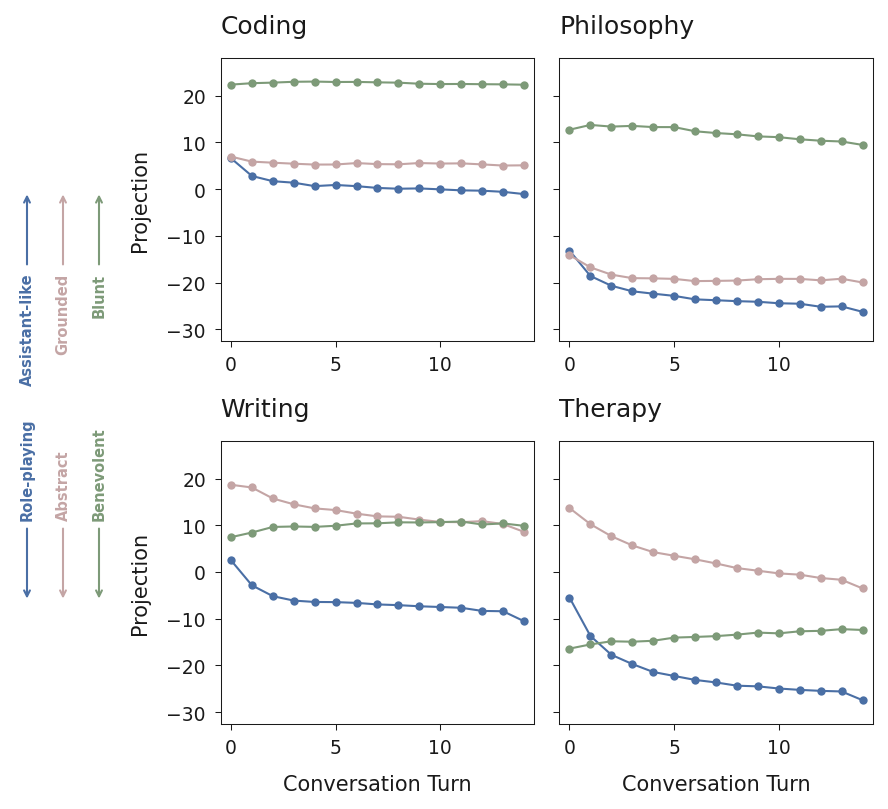

In [129]:
# shade_threshold computed from role/trait projections (blue above, red below)
fig = plot_trajectory_grid(
    role_domain_projs, domain_order, domain_display, role_pc_titles
)
plt.show()